In [1]:
path_synthetic = 'Synthetic'

In [2]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
import wandb

c:\Users\Usuario\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
import os
import pandas as pd

# Function to extract image paths and labels with corrected paths, starting from the first files
def extract_image_paths_and_labels_corrected(annotation_file, base_folder, num_images):
    image_paths = []
    labels = []
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    
    lines.sort()  # Sort the lines to ensure we start from the first files
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        image_path, _ = parts
        label = image_path.split('_')[1]
        # Correct the path separators
        corrected_image_path = os.path.join(base_folder, image_path[2:]).replace('\\', '/')
        image_paths.append(corrected_image_path)
        labels.append(label)
        if len(image_paths) >= num_images:
            break
    return image_paths, labels


# Paths to annotation files and base folders
training_folder = 'Synthetic/training_folder'
validation_folder = 'Synthetic/validation_folder'
test_folder = 'Synthetic/test_folder'

annotation_train_file = 'Synthetic/annotation_train.txt'
annotation_val_file = 'Synthetic/annotation_val.txt'
annotation_test_file = 'Synthetic/annotation_test.txt'

# Extract data with corrected image paths
train_images, train_labels = extract_image_paths_and_labels_corrected(annotation_train_file, training_folder, 200000)
val_images, val_labels = extract_image_paths_and_labels_corrected(annotation_val_file, validation_folder, 10000)
test_images, test_labels = extract_image_paths_and_labels_corrected(annotation_test_file, test_folder, 10000)

# Create dataframes
train_df = pd.DataFrame({'image_path': train_images, 'label': train_labels})
val_df = pd.DataFrame({'image_path': val_images, 'label': val_labels})
test_df = pd.DataFrame({'image_path': test_images, 'label': test_labels})

# Save to CSV files
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

# Create dictionaries from the dataframes
train_dict = train_df.to_dict(orient='records')
val_dict = val_df.to_dict(orient='records')
test_dict = test_df.to_dict(orient='records')

In [3]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
val_data = pd.read_csv("val_data.csv")

In [44]:
l =  train_data['label'].tolist()

In [51]:
if 'GUNS' in l:
    print("hay")

hay


(31, 81, 3)


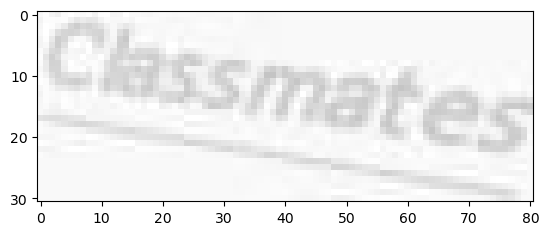

: 

In [8]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('Synthetic/training_folder/1/1/100_Classmates_13991.jpg')

cv2.imshow('image', img)
plt.imshow(img)
print(img.shape)

In [4]:
import numpy as np

def build_phoc(words, phoc_unigrams, unigram_levels, phoc_bigrams=None, bigram_levels=None, split_character=None):
    '''
    Calculate Pyramidal Histogram of Characters (PHOC) descriptor (see Almazan 2014).
    Args:
        words (list of str): list of words to calculate descriptor for
        phoc_unigrams (str): string of all unigrams to use in the PHOC
        unigram_levels (list of int): the levels for the unigrams in PHOC
        phoc_bigrams (list of str): list of bigrams to be used in the PHOC
        bigram_levels (list of int): the levels of the bigrams in the PHOC
        split_character (str): special character to split the word strings into characters (default is None)
    Returns:
        the PHOC for the given words as a numpy array
    '''
    if split_character is None:
        split_character = ''
    
    # normalized occupancy interval
    def occupancy(k, n):
        return (k / n, (k + 1) / n)

    # overlap between two intervals
    def overlap(a, b):
        return max(0, min(a[1], b[1]) - max(a[0], b[0]))

    # Initialize PHOC descriptors  levels x len(phoc) (2+3+4+5) X 36 + 2 X 50 = 504 + 100 = 604
    phoc_size = sum(unigram_levels) * len(phoc_unigrams)
    if phoc_bigrams:
        phoc_size += sum(bigram_levels) * len(phoc_bigrams)
    phocs = np.zeros((len(words), phoc_size))

    for i, word in enumerate(words):
        word_len = len(word)
        
        # Calculate unigram features
        index = 0
        for level in unigram_levels:
            region_len = word_len / level
            for region in range(level):
                region_start = region / level
                region_end = (region + 1) / level
                region_occ = (region_start, region_end)
                for char in phoc_unigrams:
                    char_occ = [occupancy(k, word_len) for k, c in enumerate(word) if c == char]
                    if any(overlap(region_occ, occ) >= 0.5 * (occ[1] - occ[0]) for occ in char_occ):
                        phocs[i, index] = 1
                    index += 1
        
        # Calculate bigram features
        if phoc_bigrams:
            for level in bigram_levels:
                region_len = word_len / level
                for region in range(level):
                    region_start = region / level
                    region_end = (region + 1) / level
                    region_occ = (region_start, region_end)
                    for bigram in phoc_bigrams:
                        bigram_occ = [occupancy(k, word_len) for k in range(word_len - 1) if word[k:k+2] == bigram]
                        if any(overlap(region_occ, occ) >= 0.5 * (occ[1] - occ[0]) for occ in bigram_occ):
                            phocs[i, index] = 1
                        index += 1

    return phocs

def phoc(raw_word):
    '''
    Convert a word into its PHOC representation.
    
    :param raw_word: string of word to be converted
    :return: phoc representation as a np.array (1, 604)
    '''
    phoc_unigrams = 'abcdefghijklmnopqrstuvwxyz0123456789'
    unigram_levels = [2, 3, 4, 5]
    phoc_bigrams = ['th', 'he', 'in', 'er', 'an',
                     're', 'on', 'at', 'en', 'nd',
                      'ti', 'es', 'or', 'te', 'of',
                       'ed', 'is', 'it', 'al', 'ar',
                        'st', 'to', 'nt', 'ng', 'se',
                         'ha', 'as', 'ou', 'io', 'le',
                          've', 'co', 'me', 'de', 'hi',
                           'ri', 'ro', 'ic', 'ne', 'ea',
                            'ra', 'ce', 'li', 'ch', 'll',
                             'be', 'ma', 'si', 'om', 'ur']
    bigram_levels = [2]

    return build_phoc([raw_word], phoc_unigrams, unigram_levels, phoc_bigrams, bigram_levels)[0]


In [19]:
"""def read_bigrams(file_txt):
    res = []
    with open(file_txt, 'r') as file:
        for line in file:
            bigram = line.split('\n')
            res.append(bigram[0])
    return res
print(read_bigrams('bigrams.txt'))
l_bigrams = read_bigrams('bigrams.txt')

phoc_bigrams = read_bigrams('bigrams.txt')"""

['th', 'he', 'in', 'er', 'an', 're', 'on', 'at', 'en', 'nd', 'ti', 'es', 'or', 'te', 'of', 'ed', 'is', 'it', 'al', 'ar', 'st', 'to', 'nt', 'ng', 'se', 'ha', 'as', 'ou', 'io', 'le', 've', 'co', 'me', 'de', 'hi', 'ri', 'ro', 'ic', 'ne', 'ea', 'ra', 'ce', 'li', 'ch', 'll', 'be', 'ma', 'si', 'om', 'ur']


In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data_frame = pd.read_csv(csv_file_path)
        self.transform = transform
        self.label_to_index = {label: idx for idx, label in enumerate(self.data_frame['label'].unique())}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        str_label = self.data_frame.iloc[idx, 1].lower()
        # label = self.label_to_index[label]¿?
        phoc_label = phoc(str_label)
        
        if self.transform:
            image = self.transform(image)

        return image, str_label, phoc_label

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Crear dataset y dataloader
csv_file_path = 'train_data.csv'  # Reemplaza con la ruta a tu archivo CSV
train_dataset = CustomDataset(csv_file_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = CustomDataset('val_data.csv',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)


In [5]:
print(test_dataset[0])

(tensor([[[-0.3541, -0.3541, -0.3541,  ..., -0.3883, -0.3883, -0.3883],
         [-0.3541, -0.3541, -0.3541,  ..., -0.3883, -0.3883, -0.3883],
         [-0.3541, -0.3541, -0.3541,  ..., -0.3883, -0.3883, -0.3883],
         ...,
         [-0.3883, -0.3883, -0.3712,  ..., -0.3369, -0.3369, -0.3369],
         [-0.3883, -0.3883, -0.3712,  ..., -0.3369, -0.3369, -0.3369],
         [-0.3883, -0.3883, -0.3712,  ..., -0.3369, -0.3369, -0.3369]],

        [[-0.2325, -0.2325, -0.2325,  ..., -0.2675, -0.2675, -0.2675],
         [-0.2325, -0.2325, -0.2325,  ..., -0.2675, -0.2675, -0.2675],
         [-0.2325, -0.2325, -0.2325,  ..., -0.2675, -0.2675, -0.2675],
         ...,
         [-0.2675, -0.2675, -0.2500,  ..., -0.2150, -0.2150, -0.2150],
         [-0.2675, -0.2675, -0.2500,  ..., -0.2150, -0.2150, -0.2150],
         [-0.2675, -0.2675, -0.2500,  ..., -0.2150, -0.2150, -0.2150]],

        [[-0.0092, -0.0092, -0.0092,  ..., -0.0441, -0.0441, -0.0441],
         [-0.0092, -0.0092, -0.0092,  ..., -

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SPP(nn.Module):

    def __init__(self, levels = 3, pool_type = 'max_pool'):
        super(SPP, self).__init__()

        if pool_type not in ['max_pool', 'avg_pool', 'max_avg_pool']:
            raise ValueError('Unknown pool_type. Must be either \'max_pool\', \'avg_pool\' or both')
        
        self.pooling_output_size = sum([4 ** level for level in range(levels)]) * 512
        self.levels = levels
        self.pool_type = pool_type

    def forward(self, input_x):
        out = self._spatial_pyramid_pooling(input_x, self.levels)
        return out
    
    def _pyramid_pooling(self, input_x, output_sizes):
        pyramid_level_tensors = []
        for tsize in output_sizes:
            if self.pool_type == 'max_pool':
                pyramid_level_tensor = F.adaptive_max_pool2d(input_x, tsize)
                pyramid_level_tensor = pyramid_level_tensor.view(input_x.size(0), -1)
            if self.pool_type == 'avg_pool':
                pyramid_level_tensor = F.adaptive_avg_pool2d(input_x, tsize)
                pyramid_level_tensor = pyramid_level_tensor.view(input_x.size(0), -1)
            if self.pool_type == 'max_avg_pool':
                pyramid_level_tensor_max = F.adaptive_max_pool2d(input_x, tsize)
                pyramid_level_tensor_max = pyramid_level_tensor_max.view(input_x.size(0), -1)
                pyramid_level_tensor_avg = F.adaptive_avg_pool2d(input_x, tsize)
                pyramid_level_tensor_avg = pyramid_level_tensor_avg.view(input_x.size(0), -1)
                pyramid_level_tensor = torch.cat([pyramid_level_tensor_max, pyramid_level_tensor_avg], dim=1)

            pyramid_level_tensors.append(pyramid_level_tensor)

        return torch.cat(pyramid_level_tensors, dim=1)

    def _spatial_pyramid_pooling(self, input_x, levels):
        output_sizes = [(int( 2 **level), int( 2 **level)) for level in range(levels)]
        return self._pyramid_pooling(input_x, output_sizes)

# Phocnet implementation from PHOCNet GH Repo
class PHOCNet(nn.Module):

    def __init__(self, n_out, input_channels = 3, pooling_levels = 3, pool_type = 'max_pool'):
        super(PHOCNet, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.pooling_layer_fn = SPP(levels = pooling_levels, pool_type=pool_type)
        pooling_output_size = self.pooling_layer_fn.pooling_output_size
        
        self.fc1 = nn.Linear(pooling_output_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_out)

    def forward(self, x):
        out = self.conv_block1(x)
        out = F.max_pool2d(out, kernel_size=2, stride=2, padding=0)
        out = self.conv_block2(out)
        out = F.max_pool2d(out, kernel_size=2, stride=2, padding=0)
        out = self.conv_block3(out)
        out = self.conv_block4(out)

        out = self.pooling_layer_fn(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = F.dropout(out, p = 0.5, training = self.training)
        out = self.fc2(out)
        out = F.relu(out)
        out = F.dropout(out, p = 0.5, training = self.training)
        out = self.fc3(out)

        return out

    # distribución normal con media cero
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
    

In [7]:
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, config, device = "cuda"):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    example_ct = 0  # number of examples seen
    batch_ct = 0
    model_phoc = load_model()
    for epoch in tqdm(range(config.epochs)):
        model.train()
        train_loss = 0
        for _, (images, phoc_labels, _) in enumerate(train_loader):

            loss = train_batch(images, phoc_labels, model, optimizer, criterion, device)
            train_loss += loss.item()
            example_ct +=  len(images)
            batch_ct += 1

            #Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss.item(), example_ct)
        
        # loss_test = test(model, test_loader, train_loader, epoch, criterion, model_phoc, device)
        
        # scheduler.step(loss_test)
        # print(scheduler._last_lr)
        torch.save(model.state_dict(), os.path.join(config.save_model, f"PHOCNET{epoch}.pt"))
    return model

def train_batch(images, labels, model, optimizer, criterion, device="cuda"):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs.float(), labels.float())
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [8]:

def test(model, test_loader, train_loader, epoch, criterion, model_phoc, device="cuda", save:bool= True):
    # Run the model on some test examples
    model.eval()
    with torch.no_grad():
        loss_test = 0
        loss_train = 0
        correct_test = 0
        correct_train = 0
        edit_test = 0
        edit_train = 0
        test_count = 0
        train_count = 0
        
        for i, (images, phoc_labels, text_labels) in enumerate(test_loader):
            images, phoc_labels = images.to(device), phoc_labels.to(device)
            test_count += len(images)
            outputs = model(images)
            loss_test += criterion(outputs, phoc_labels.float()) 
            predicted_labels = predict_with_PHOC(torch.sigmoid(outputs).cpu().numpy(), model_phoc)
            correct_test += (predicted_labels == text_labels).sum().item()
            edit_test += sum([editdistance.eval(p,t) for p,t in zip(predicted_labels, text_labels)])
            if i == 0:
                log_images(images, predicted_labels, text_labels[:5], epoch, "Test")
                
        for i, (images, phoc_labels, text_labels) in enumerate(train_loader):
            images, phoc_labels = images.to(device), phoc_labels.to(device)
            train_count += len(images)
            outputs = model(images)
            loss_train += criterion(outputs, phoc_labels.float()) 
            predicted_labels = predict_with_PHOC(torch.sigmoid(outputs).cpu().numpy(), model_phoc)
            correct_train += (predicted_labels == text_labels).sum().item()
            edit_train += sum([editdistance.eval(p,t) for p,t in zip(predicted_labels, text_labels)])
            if i == 0:
                log_images(images, predicted_labels, text_labels[:5], epoch, "Train")
            if i == 150:
               break

        loss_test = loss_test/len(test_loader)
        loss_train = loss_train/(i+1)    
        accuracy_test = correct_test/test_count
        accuracy_train = correct_train/train_count
        edit_test = edit_test/test_count
        edit_train = edit_train/train_count 

        train_test_log(loss_test, loss_train, accuracy_test, accuracy_train, edit_test, edit_train, epoch)
    return loss_test

In [ ]:
n_out = 604
criterion = nn.CrossEntropylosws
optimizer = 
scheduler = 
config = 

model = PHOCNet(n_out)


In [61]:
train(model, train_loader, test_loader, criterion, optimizer, scheduler, config, device = "cuda")

In [ ]:
wandb.init(project="phocnet_project", config={"epochs": 20, "batch_size": 32, "learning_rate": 0.001})
config = wandb.config

model = PHOCNet(num_outputs=604).to('cuda')  # Ajusta el número de salidas según sea necesario
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train(model, train_loader, test_loader, criterion, optimizer, scheduler, config)


604
